# 0. Libraries

In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications import InceptionV3
from tensorflow.image import resize

# 1. Data Preprocessing

In [2]:
# Data loading
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

batch_1 = unpickle("data/data_batch_1")
batch_2 = unpickle("data/data_batch_2")
batch_3 = unpickle("data/data_batch_3")
batch_4 = unpickle("data/data_batch_4")
batch_5 = unpickle("data/data_batch_5")
test_batch = unpickle("data/test_batch")
label_names = unpickle("data/batches.meta")

In [3]:
# Turn the labels lists into np.arrays()
batch_1[b'labels'] = np.asarray(batch_1[b'labels'])
batch_2[b'labels'] = np.asarray(batch_2[b'labels'])
batch_3[b'labels'] = np.asarray(batch_3[b'labels'])
batch_4[b'labels'] = np.asarray(batch_4[b'labels'])
batch_5[b'labels'] = np.asarray(batch_5[b'labels'])
test_batch[b'labels'] = np.asarray(test_batch[b'labels'])

In [4]:
# Reshape every image from (3073,) to (32,32,3)so we can see it with plt.imshow()
def reshape_transpose(batch):
    images = batch[b"data"].reshape(10000, 3, 32, 32) # Because of how np.reshape works, this returns an array with np.shape=(10000,3,32,32)
    images = images.transpose(0,2,3,1) # We transpose it so it has the correct np.shape=(10000,32,32,3) for plt.imshow()
    return images

images1 = reshape_transpose(batch_1)
images2 = reshape_transpose(batch_2)
images3 = reshape_transpose(batch_3)
images4 = reshape_transpose(batch_4)
images5 = reshape_transpose(batch_5)
test_images = reshape_transpose(test_batch)

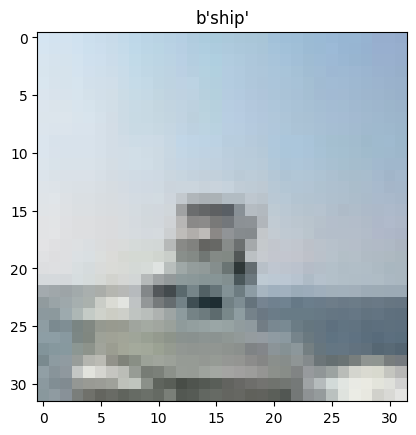

In [5]:
# Visualize one image to check if it worked
n = 100
image = images1[n] # This returns the n-th image from images1
image_label_int = batch_1[b'labels'][n] # This returns the label of the n-th image from images1 as an int (eg: if n=0, a 6)
image_label_str = label_names[b'label_names'][image_label_int] # This takes the label of the n-th image from images1 and returns the corresponding str-label (eg: if n=0, 6 --> "frog")

plt.imshow(image)
plt.title(f"{image_label_str}")
plt.show()

# 2. Model Architecture

In [6]:
# Prepare the data
num_classes = len(label_names[b'label_names']) # Length of the label_names list --> 10
sample_size = 10000

# We don't need to do a train_test_split because the data is already split
X_train = images1[:sample_size]
y_train = batch_1[b'labels'][:sample_size]
X_test = test_images[:sample_size]
y_test = test_batch[b'labels'][:sample_size]

# Convert labels to categorical. This way, every int [0:10] is a class and it won't be treated as continous
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

In [7]:
# Model parameters
input_shape = X_train[0].shape # Shape of any image from any of the batches --> (32, 32, 3)

# Model Architecture
model = keras.Sequential([
        keras.Input(shape=input_shape),

        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        # layers.Dropout(0.4),

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        # layers.Dropout(0.4),

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        # layers.Dropout(0.4),

        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.4),
        
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        # layers.MaxPooling2D(pool_size=(2, 2)),
        # layers.Dropout(0.4),
        
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        # layers.Dropout(0.4),
        
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        # layers.MaxPooling2D(pool_size=(2, 2)),
        # layers.Dropout(0.4),
        
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.4),

        layers.Dense(128, activation="relu"),
        # layers.Dropout(0.4),

        layers.Flatten(),
        
        layers.Dense(num_classes, activation="softmax")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4, 4, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4, 4, 128)      │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,236,618 (4.72 MB)

 Trainable params: 1,234,762 (4.71 MB)

 Non-trainable params: 1,856 (7.25 KB)

# 3. Model Training

In [8]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy", "precision", "recall"])

batch_size = 128
epochs = 30
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 60s 756ms/step - accuracy: 0.2810 - loss: 2.0590 - precision: 0.4018 - recall: 0.0889 - val_accuracy: 0.1080 - val_loss: 2.5025 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 52s 734ms/step - accuracy: 0.4603 - loss: 1.4773 - precision: 0.6139 - recall: 0.2786 - val_accuracy: 0.1150 - val_loss: 2.7252 - val_precision: 0.3333 - val_recall: 0.0010
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 53s 740ms/step - accuracy: 0.5463 - loss: 1.2512 - precision: 0.6887 - recall: 0.3836 - val_accuracy: 0.1430 - val_loss: 3.3741 - val_precision: 1.0000 - val_recall: 0.0020
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 53s 740ms/step - accuracy: 0.6045 - loss: 1.0983 - precision: 0.7313 - recall: 0.4583 - val_accuracy: 0.1510 - val_loss: 3.4151 - val_precision: 0.1786 - val_recall: 0.1120
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 52s 735ms/step - accuracy: 0.6521 - loss: 0.9519 - precision: 0.7696 - recall: 0.5411 - val_accuracy: 0.2580 -

# 4. Model Evaluation

In [9]:
y_train_pred = np.argmax(model.predict(X_train), axis=1) # Turn the predictions from a float to an int so they match the labels
y_test_pred = np.argmax(model.predict(X_test), axis=1) # Turn the predictions from a float to an int so they match the labels

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step


In [10]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test precision:", score[2])
print("Test recall:", score[3])

Test loss: 1.4801626205444336
Test accuracy: 0.722100019454956
Test precision: 0.7344714403152466
Test recall: 0.7142000198364258


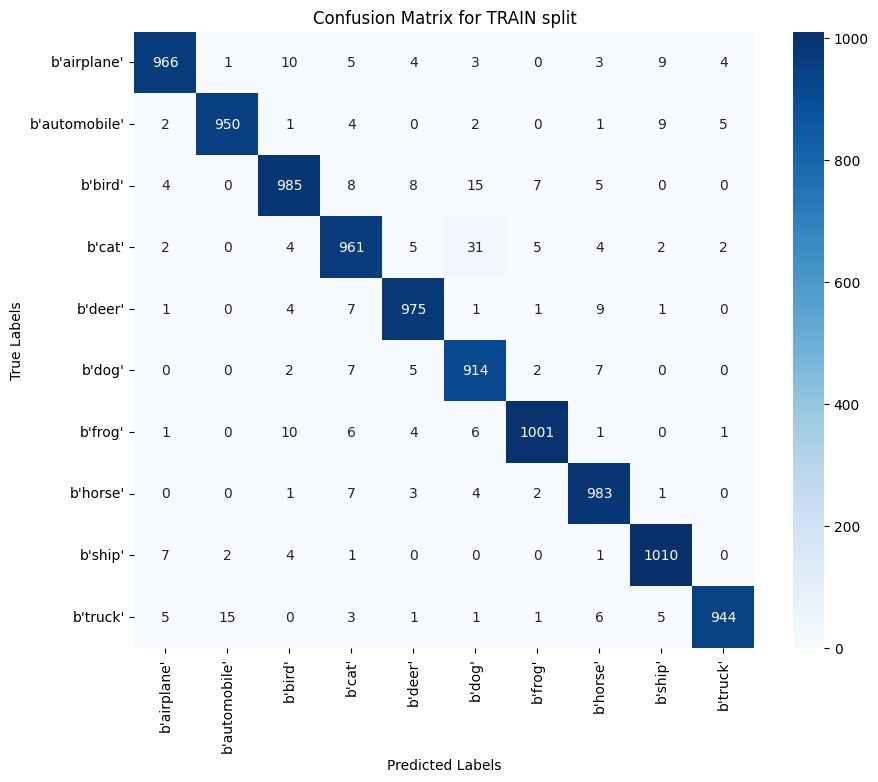

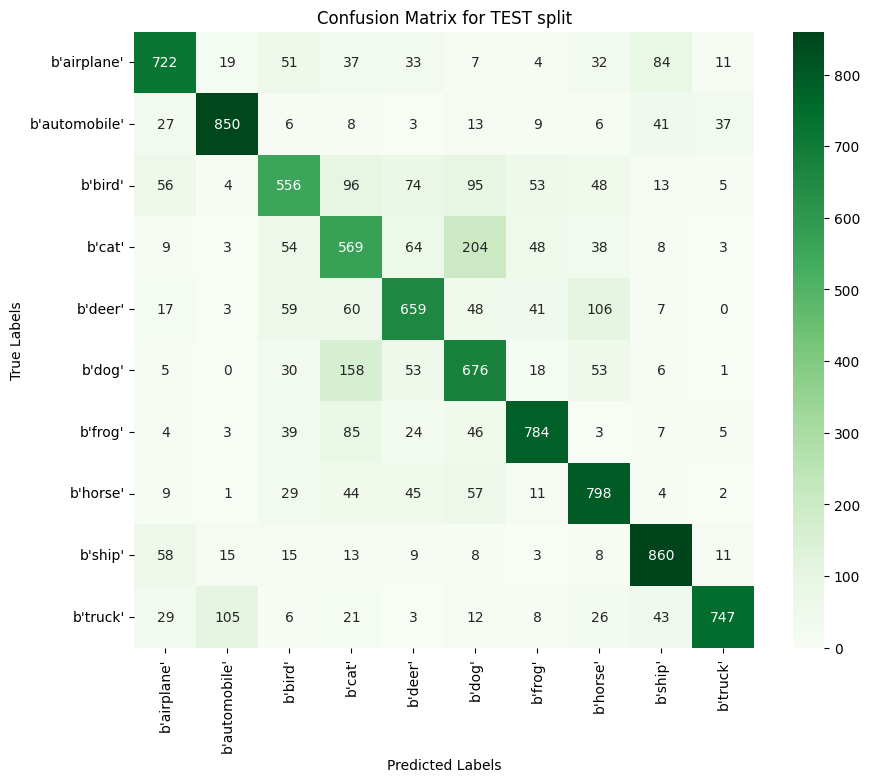

In [11]:
conf_matrix_train = confusion_matrix(np.argmax(y_train, axis=1), y_train_pred)
conf_matrix_test = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)

# Confusion matrix for train data
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix_train,
            annot=True, fmt="d",
            cmap="Blues",
            xticklabels=label_names[b'label_names'],
            yticklabels=label_names[b'label_names']
            )
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for TRAIN split")
plt.show()

# Confusion matrix for test data
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix_test,
            annot=True,
            fmt="d",
            cmap="Greens",
            xticklabels=label_names[b'label_names'],
            yticklabels=label_names[b'label_names'],
            )
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for TEST split")
plt.show()

In [12]:
# Save the trained model
pickle.dump(model, open(f"trained_model_acc_{score[1]:.4f}.pkl", "wb"))

# 5. Transfer Learning

In [7]:
# Preprocess the data to adapt it to the Inception model
X_train_inception= resize(X_train, (75,75))
X_test_inception = resize(X_test, (75,75))

# Model parameters
input_shape_inception = X_train_inception[0].shape

In [8]:
# Extract the Inception pre-trained model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape_inception) # weights='imagenet' loads the model trained on the ImageNet dataset. include_top=False stops the model from loading the top layer

In [9]:
base_model.trainable = False # Freeze the layers of the base model

avg = GlobalAveragePooling2D()(base_model.output) # This layer transforms 2D into 1D, or from a Convolution layer to a Dense layer
output = Dense(num_classes, activation="softmax")(avg) # This layer classifies the input into one of n_classes categories

combined_model = Model(inputs=base_model.input, outputs=output) # Combining these layers to create the combined model of Inception with a new top layer

In [11]:
# Create a checkpoint to save the model while it's training
checkpoint = ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras',  # Path to save the model file
    monitor='val_accuracy',          # Metric to monitor
    save_best_only=True,             # Save only the best model (based on monitored metric)
    mode='max',                      # Minimize the monitored metric (for 'val_loss', use 'min'; for accuracy, use 'max')
    save_weights_only=False,         # Whether to save the whole model or just the weights
    verbose=0
)

In [12]:
# Train the new top layer with a high learning rate
combined_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.2), metrics=["accuracy", "precision", "recall"])

batch_size_inception = 128
epochs_inception = 10
history = combined_model.fit(X_train_inception,
                             y_train,
                             batch_size=batch_size_inception,
                             epochs=epochs_inception,
                             validation_split=0.1,
                             callbacks=[checkpoint]
                             )

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 61s 702ms/step - accuracy: 0.3405 - loss: 24.9689 - precision: 0.3568 - recall: 0.3357 - val_accuracy: 0.4910 - val_loss: 11.6513 - val_precision: 0.4900 - val_recall: 0.4890
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 625ms/step - accuracy: 0.5791 - loss: 8.1029 - precision: 0.5805 - recall: 0.5778 - val_accuracy: 0.4340 - val_loss: 16.5199 - val_precision: 0.4346 - val_recall: 0.4320
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 574ms/step - accuracy: 0.5986 - loss: 8.5365 - precision: 0.6010 - recall: 0.5972 - val_accuracy: 0.4800 - val_loss: 14.2902 - val_precision: 0.4805 - val_recall: 0.4800
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 577ms/step - accuracy: 0.6213 - loss: 7.6500 - precision: 0.6229 - recall: 0.6210 - val_accuracy: 0.4990 - val_loss: 14.0808 - val_precision: 0.4990 - val_recall: 0.4970
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 556ms/step - accuracy: 0.6495 - loss: 7.1959 - precision: 0.6503 - recall: 0.6489 - val_accuracy: 0.4920 - va

In [13]:
# Fine-tune the whole model
base_model.trainable = True # Unfreeze the layers of the base model

for layer in base_model.layers[:150]: # Freeze only some layers of the base model to avoid overfitting
    layer.trainable = False

combined_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy", "precision", "recall"]) # Use a low learning rate so the pre-trained weights don't change much

history = combined_model.fit(X_train_inception,
                             y_train,
                             batch_size=batch_size_inception,
                             epochs=epochs_inception,
                             validation_split=0.1,
                             callbacks=[checkpoint]
                             )

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.2631 - loss: 34.2797 - precision: 0.2648 - recall: 0.2602 - val_accuracy: 0.2560 - val_loss: 42.2205 - val_precision: 0.2568 - val_recall: 0.2550
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.4055 - loss: 5.8973 - precision: 0.4317 - recall: 0.3853 - val_accuracy: 0.2520 - val_loss: 16.7927 - val_precision: 0.2535 - val_recall: 0.2510
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.4891 - loss: 3.2371 - precision: 0.5478 - recall: 0.4376 - val_accuracy: 0.3450 - val_loss: 8.2355 - val_precision: 0.3557 - val_recall: 0.3390
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.5406 - loss: 2.3791 - precision: 0.6107 - recall: 0.4874 - val_accuracy: 0.4770 - val_loss: 4.7262 - val_precision: 0.5213 - val_recall: 0.4290
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.5928 - loss: 1.8556 - precision: 0.6766 - recall: 0.5174 - val_accuracy: 0.5040 - val_loss: 3.45

In [65]:
# score_inception = model.evaluate(X_test_inception, y_test, verbose=0)
# print("Test loss:", score_inception[0])
# print("Test accuracy:", score_inception[1])
# print("Test precision:", score_inception[2])
# print("Test recall:", score_inception[3])

In [66]:
# y_pred_inception = np.argmax(model.predict(X_test_inception), axis=1)

In [ ]:
# conf_matrix_inception = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)

# plt.figure(figsize=(10,8))
# sns.heatmap(conf_matrix_inception,
#             annot=True,
#             fmt="d",
#             cmap="Greens",
#             xticklabels=label_names[b'label_names'],
#             yticklabels=label_names[b'label_names'],
#             )
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Confusion Matrix for TEST split")
# plt.show()

In [14]:
# Save the combined model
pickle.dump(combined_model, open("combined_model.pkl", "wb"))